<a href="https://colab.research.google.com/github/cfoli/AI-4-Financial-Modeling/blob/main/House%20sale%20price%20forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# FNCE/BTEC 494: AI For Financial Modeling
# Spring '24
# Author: Prof. Jay D. Vaidya

# This Jupyter Notebook should serve as an example you can use to build your ML pipelines and undertake your
# modeling; it does NOT, however, represent the requirements for this A2 assignment. Please refer to the A2
# write-up for details on the assignment requirements.

In [1]:
# Let's begin by importing several packages we are likely to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# We will also be using several SKLearn packages specific to building ML pipelines, as well as those used in
# generating and fitting our models. We will import them here, too.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read in our dataset(s), 'train' and 'test'; I have uploaded my datasets to my current session,
# so the filepath used to read in my data will reflect this

train = pd.read_csv('/content/drive/Shareddrives/AI for Financial Modeling Group 6/Module 2/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/AI for Financial Modeling Group 6/Module 2/test.csv')

# Quick print statement which prints the shape of each DF
print('\n', 'Train dataset shape:', train.shape[0],'x', train.shape[1],'\n'
      'Test dataset shape:', test.shape[0],'x', test.shape[1])


 Train dataset shape: 1460 x 81 
Test dataset shape: 1459 x 80


In [7]:
# Let's look at the head and tail of training dataset
train.head(15)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


### We should immediately take note of the following characteristics of the training data:

*   There are a mixture of 1) Numeric (i.e., interger & real num.); 2) Categorical (i.e., strings with inherent meaning, but not subject to ranking); and 3) Ordinal (strings or numeric data in which the order between categories imparts meaning) data
*   There are a significant number of missing records in some of the features (i.e., columns) which will require attention before we try to fit any models
*   The scale of various numeric features is SIGNIFICANTLY different; this may be an early indication that some form of feature scaling is appropriate



In [8]:
# It is difficult to view all of the columns in the DF format; we can call on the attribute
# 'columns' for the DF in order to get a list of the columns
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
# We use the .info() method to get more information on the types of data and prevalence
# of missing - or null - records in each feature
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### At This point, you should undertake your Exploratory Data Analysis (EDA) before proceeding any further. You may want to answer for yourselves some of the following questions:


1.   What are the distributions of values for your features (are they normally distributed, highy skewed, or mostly missing?)
2.   Are there any significant correlations between variables that may lead to multicollinearity issues? If so - what options may we use to address these issues?
3.   Is it best to retain all of the available features, or is there a good reason to eliminate (i.e. drop) some? If so, why?



In [ ]:
## YOUR EDA BEGINS HERE!!! ##
## Generate as many new code cells as needed, below, to undertake your EDA ##
train.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


<Axes: >

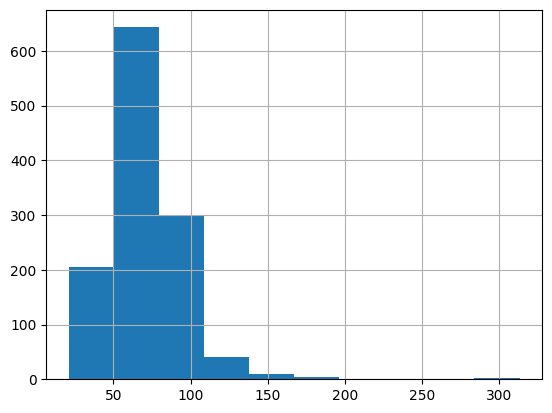

In [16]:
train['LotFrontage'].hist()

## Let's be sure to use a pipeline for our data in order to make our data cleaning and feature engineering processes repeatable, as well as easily changeable in the event we determine to use a different approach

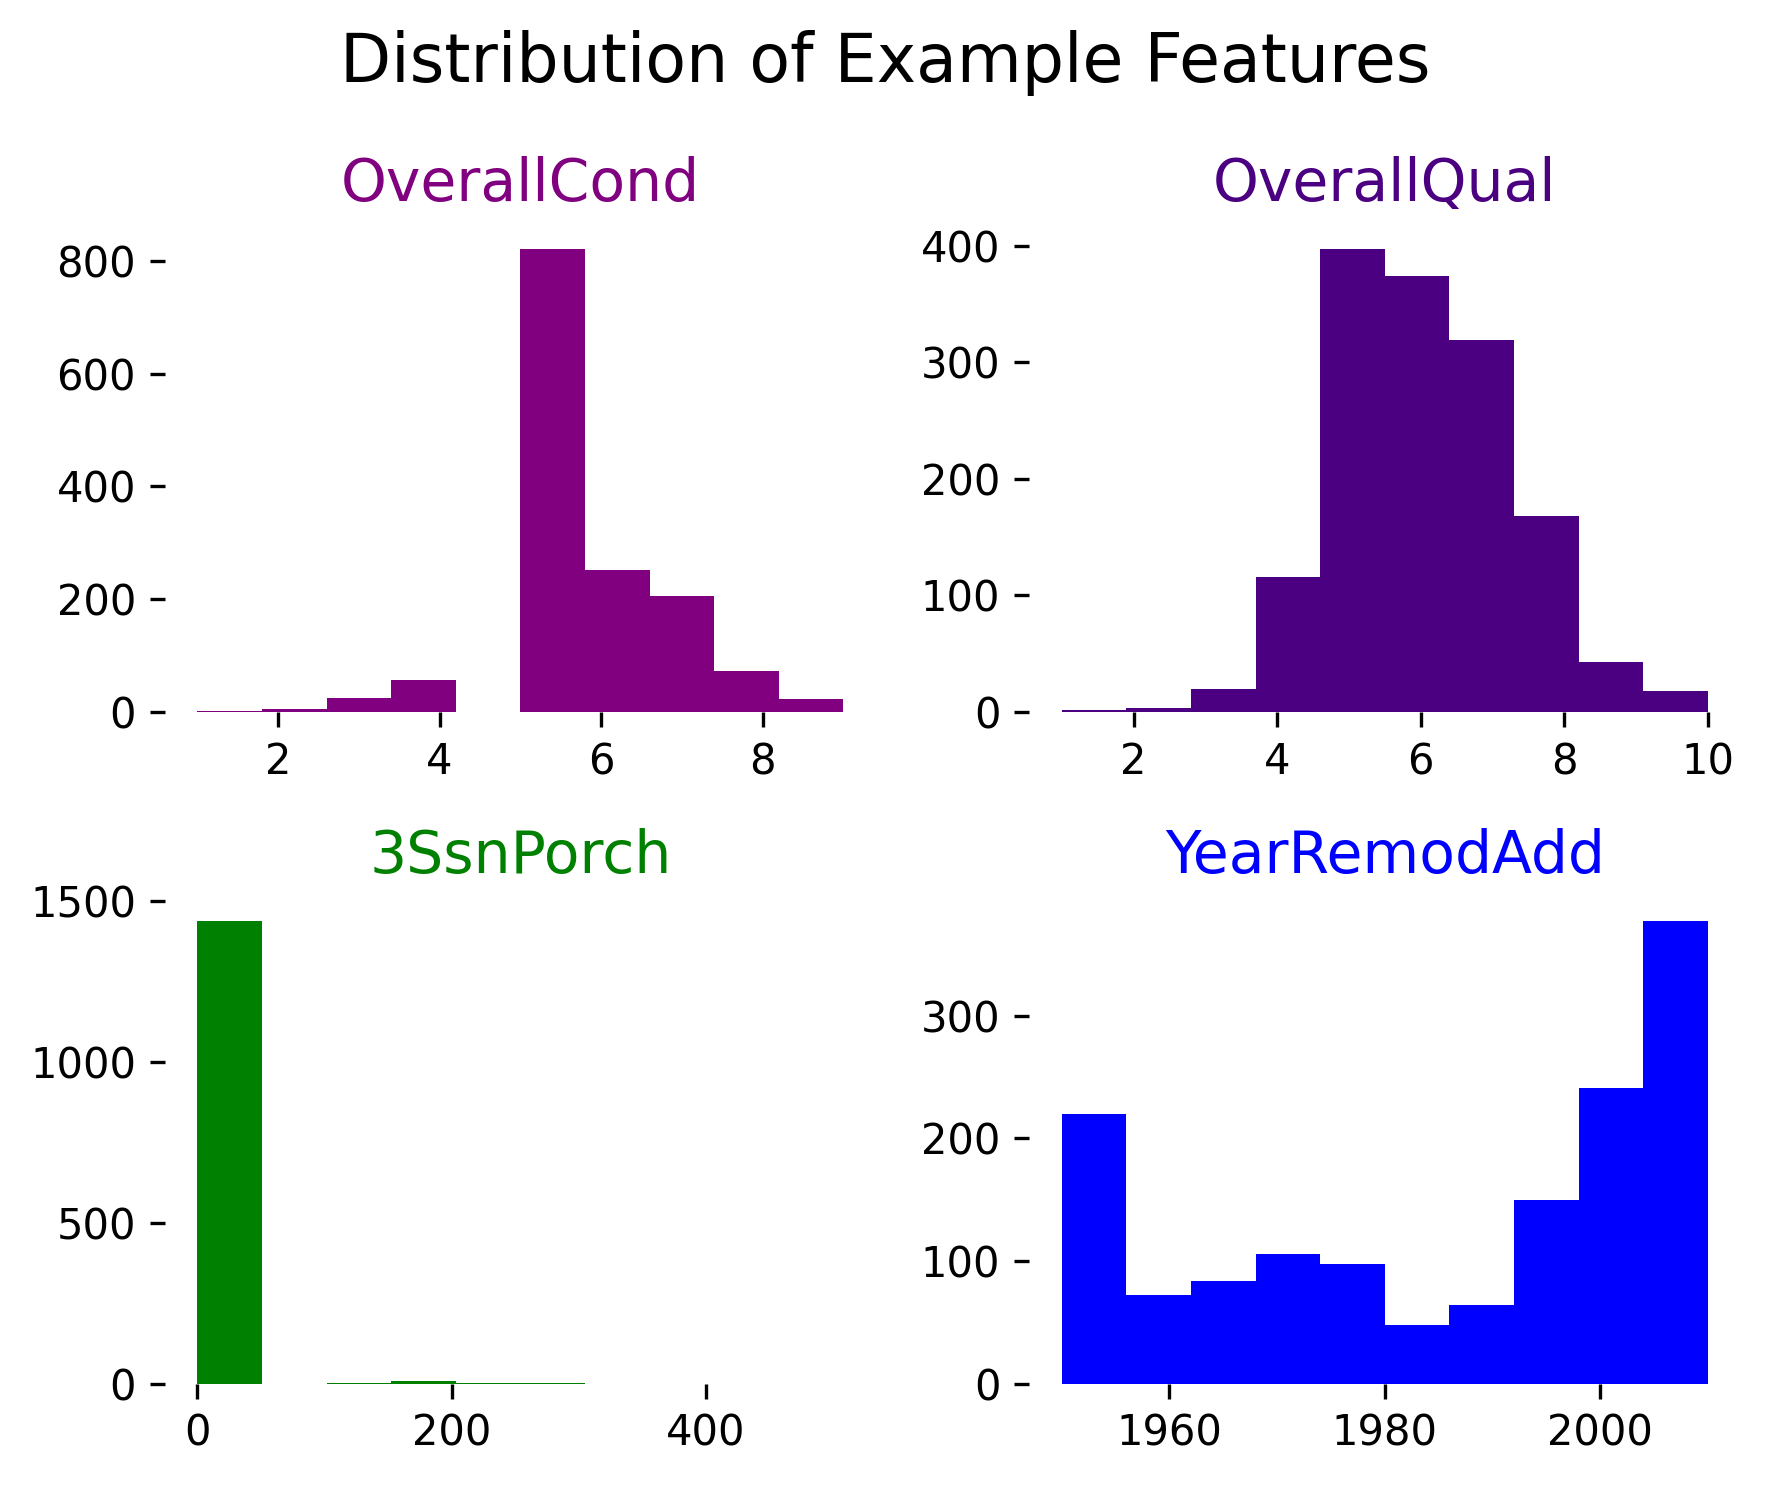

In [33]:
features_to_plot = ['OverallCond','OverallQual','3SsnPorch','YearRemodAdd'] # LotFrontage
ax_colors = ['purple','indigo','green','blue']
fig,axes  = plt.subplots(2,2,figsize=(6,5),dpi=300)
axes = axes.flatten()

for idx,ax in enumerate(axes):
  train[features_to_plot[idx]].hist(ax=ax,bins=10,grid=False,color=ax_colors[idx])
  ax.set_title(features_to_plot[idx], fontsize=14,c=ax_colors[idx])
  ax.spines[:].set_visible(False)

plt.suptitle('Distribution of Example Features',fontsize=16)
plt.tight_layout()
plt.show()


In [34]:
# First, let's generate a list of the unique data types present in our training dataset
# Recall that a "set" is a tuple of non-repeating entries. So by passing our "dtypes" into
# a set, we end up with a list with one instance of each datatype
train_dtypes = list(set(train.dtypes))
train_dtypes

[dtype('O'), dtype('float64'), dtype('int64')]

In [35]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


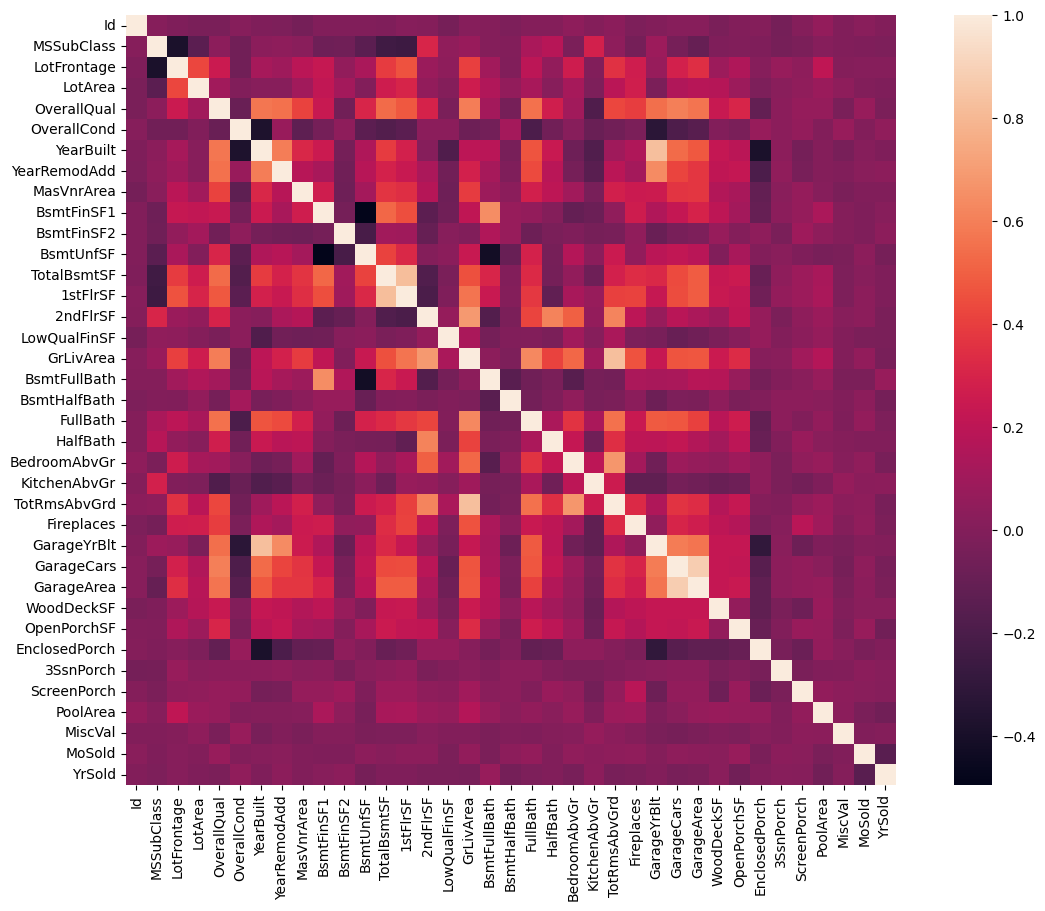

In [38]:
import seaborn as sns

plt.figure(figsize=(15, 10))
corr_mat = train.drop(columns=['SalePrice']).corr(numeric_only=True)
sns.heatmap(corr_mat,square=True)
plt.show()

corr_thresh = 0.5
#corr_mat[abs(corr_mat) > corr_thresh]

In [40]:
# Get pairs of features that have correlation above the threshold
high_corr_pairs = []
for i in range(len(corr_mat.columns)):
    for j in range(i):
        if abs(corr_mat.iloc[i, j]) > corr_thresh:
            high_corr_pairs.append((corr_mat.columns[i], corr_mat.columns[j], corr_mat.iloc[i, j]))

# Convert to a DataFrame for better visualization
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df = high_corr_df.sort_values('Correlation', ascending=False)
print(high_corr_df)


       Feature 1     Feature 2  Correlation
27    GarageArea    GarageCars     0.882475
20   GarageYrBlt     YearBuilt     0.825667
16  TotRmsAbvGrd     GrLivArea     0.825489
5       1stFlrSF   TotalBsmtSF     0.819530
8      GrLivArea      2ndFlrSF     0.687501
18  TotRmsAbvGrd  BedroomAbvGr     0.676620
9   BsmtFullBath    BsmtFinSF1     0.649212
21   GarageYrBlt  YearRemodAdd     0.642277
11      FullBath     GrLivArea     0.630012
15  TotRmsAbvGrd      2ndFlrSF     0.616423
12      HalfBath      2ndFlrSF     0.609707
22    GarageCars   OverallQual     0.600671
6      GrLivArea   OverallQual     0.593007
2   YearRemodAdd     YearBuilt     0.592855
24    GarageCars   GarageYrBlt     0.588920
0      YearBuilt   OverallQual     0.572323
7      GrLivArea      1stFlrSF     0.566024
26    GarageArea   GarageYrBlt     0.564567
25    GarageArea   OverallQual     0.562022
17  TotRmsAbvGrd      FullBath     0.554784
1   YearRemodAdd   OverallQual     0.550684
10      FullBath   OverallQual  

In [42]:
# As we prepare our data for our pipeline transformations, we will need to specify to the transformers where our
# numeric data is located and where our categorical data is located. There are NUMEROUS ways to accomplish this task.
# One such method, shown below, is to separate our numeric and categorical variables into distinct objects, and then
# pass those objects directly to their respective transformers. This method is shown below.

# We need to generate a new object to contain our numeric training data, but this object should not include the "SalePrice"
# feature, which will be our predictor (i.e., 'y') variable when training our models
train_numeric_data = train.select_dtypes(include=[pd.Float64Dtype, pd.Int64Dtype]).drop(columns=['SalePrice'], axis=1)
train_numeric_data


<ipython-input-42-1816dcfe9366>:8: UserWarning: Instantiating Float64Dtype without any arguments.Pass a Float64Dtype instance to silence this warning.
  train_numeric_data = train.select_dtypes(include=[pd.Float64Dtype, pd.Int64Dtype]).drop(columns=['SalePrice'], axis=1)
<ipython-input-42-1816dcfe9366>:8: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  train_numeric_data = train.select_dtypes(include=[pd.Float64Dtype, pd.Int64Dtype]).drop(columns=['SalePrice'], axis=1)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,548,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,460,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,608,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,642,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,460,0,40,0,0,0,0,0,8,2007
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,500,349,0,0,0,0,0,0,2,2010
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,252,0,60,0,0,0,0,2500,5,2010
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,240,366,0,112,0,0,0,0,4,2010


In [44]:
# As we did above, we will generate a new object to house our categorical features, this time by passing all
# 'object' dtypes as our filter
train_cat_ord_data = train.select_dtypes(include=object)
train_cat_ord_data

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### Before moving on to the pipeline (detailed below) let's ask ourselves a few questions:


1.   Could we benefit from segmenting some of the ordinal data in the "train_ord_cat_data" into a new object, then encoding them as ordinal data instead of using the one-hot-encoder as shown below?
2.   Are all of our numeric features (i.e., 'Id', 'YearBuilt', 'YearRemodAdded', 'YearSold') truly numeric in nature, or might they be more accurately considered categorical?

### Testing out some of these questions may lead to improvement over the performance of the model shown below...



In [45]:
# We will establish separate pipelines for the numeric and categorical data in our dataset.
# The types of feature engineering and imputation strategies I've chosen are by no means the best avaiable,
# they are simply a starting point. Please feel encouraged to experiment - and report on the results of
# those experiments in your A2 write-up.

num_pipeline = sklearn.pipeline.Pipeline(
    steps = [('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())]
)

cat_pipeline = sklearn.pipeline.Pipeline(
    steps = [('cat_imputer', SimpleImputer(strategy='most_frequent')),
             ("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# The ColumnTransformer allows us to combine multiple pipelines into one new object, so when we go to pass our
# unaltered training data into our transformaiton pipeline, we can accomplish the task using one "fit_transform()"
# method.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, train_numeric_data.columns),
        ('cat', cat_pipeline, train_cat_ord_data.columns), # input order: ('name', transformer, columns)
    ]
)


In [ ]:
# We can use the fit_transform() method to enact our data pipeline on our training data
processed_train_data = preprocessor.fit_transform(train)

In [ ]:
# We've generated a 'sparse' matrix, which has special data compression properties in Python
processed_train_data

<1460x288 sparse matrix of type '<class 'numpy.float64'>'
	with 116800 stored elements in Compressed Sparse Row format>

In [ ]:
# We can't pass back the column names from the original 'train' DF; we've generated many
# new columns as the result of our one-hot-encoding. Nevertheless, we can still generate
# a dataframe in order to help visualize the data transformations we've undertaken
pd.DataFrame.sparse.from_spmatrix(processed_train_data, index=None, columns=None)

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
0,-1.730865,0.073375,-0.220875,-0.207142,0.651479,-0.5172,1.050994,0.878668,0.514104,0.575425,...,0,0,0,1.0,0,0,0,0,1.0,0
1,-1.728492,-0.872563,0.46032,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.57075,1.171992,...,0,0,0,1.0,0,0,0,0,1.0,0
2,-1.72612,0.073375,-0.084636,0.07348,0.651479,-0.5172,0.984752,0.830215,0.325915,0.092907,...,0,0,0,1.0,0,0,0,0,1.0,0
3,-1.723747,0.309859,-0.44794,-0.096897,0.651479,-0.5172,-1.863632,-0.720298,-0.57075,-0.499274,...,0,0,0,1.0,1.0,0,0,0,0,0
4,-1.721374,0.073375,0.641972,0.375148,1.374795,-0.5172,0.951632,0.733308,1.366489,0.463568,...,0,0,0,1.0,0,0,0,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.357114,-0.26056,-0.071836,-0.5172,0.918511,0.733308,-0.57075,-0.973018,...,0,0,0,1.0,0,0,0,0,1.0,0
1456,1.723747,-0.872563,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,...,0,0,0,1.0,0,0,0,0,1.0,0
1457,1.72612,0.309859,-0.175462,-0.14781,0.651479,3.07857,-1.002492,1.024029,-0.57075,-0.369871,...,0,0,0,1.0,0,0,0,0,1.0,0
1458,1.728492,-0.872563,-0.084636,-0.08016,-0.795151,0.381743,-0.704406,0.539493,-0.57075,-0.865548,...,0,0,0,1.0,0,0,0,0,1.0,0


In [ ]:
# We can generate a list of the newly created one_hot_encoded features using the code snippet below DONNY STEINBERG
new_one_hot_features = preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(train_cat_ord_data.columns)
new_one_hot_features

array(['MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl',
       'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3',
       'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub',
       'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_

### Below, I will fit a Lasso Regression model in order to demonstrate the process. For your A2 assignment, please be sure the reference the assignment guidelines, which require you to test a variety of 'alpha' values, finding the best resultant value for your modeling work.

In [ ]:
# Generate an instance of your model; be sure to specify the alpha value, which will control the regularization
# term applied to the loss function
lasso_reg = Lasso(alpha=0.001, max_iter=10000, selection='cyclic')
lasso_reg.fit(processed_train_data, train['SalePrice'])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105993324464.95477, tolerance: 920791133.4609975
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso(alpha=0.001, max_iter=10000)

In [ ]:
# We can view an array of the coefficients calculated based on our Lasso Regression fit
lasso_reg.coef_

array([ 4.35022468e+02, -2.20252069e+03,  8.97960710e+02,  7.34055887e+03,
        8.87348365e+03,  6.44756548e+03,  9.21070747e+03,  2.05474117e+03,
        3.05375121e+03,  1.27659150e+04,  3.08343652e+03,  3.95968178e+03,
        2.51833237e+03,  1.64183422e+04,  2.48490592e+04, -2.94481111e+02,
        3.72174089e+03,  5.49512073e+02, -2.11933265e+02,  2.20070590e+03,
        8.93025605e+02, -2.96896845e+03, -2.81386950e+03,  2.51335229e+03,
        1.80455883e+03,  5.87228357e+02,  2.21844286e+03,  2.98793246e+03,
        1.92845568e+03,  3.61075141e+02,  1.16402148e+02,  9.24580572e+02,
        1.90302890e+03,  3.91996824e+03,  1.73812523e+03, -1.27005742e+03,
       -6.71336347e+02, -2.44935709e+04,  1.09663458e+04,  1.49453034e+03,
        3.36222323e+03, -1.41221646e+03, -3.20806212e+04,  5.67678845e-11,
       -1.29515070e+03,  6.89479164e-11, -1.96272406e+03,  2.91886853e+03,
        3.19289036e+03, -1.50847377e+02, -6.36971044e+03,  2.38376498e+03,
       -1.54316048e+04,  

In [ ]:
# Generate a list of the features in our transformed training dataset;
# This list requires that the features be passed back in the same order the model was fitted
feature_list = list(train_numeric_data.columns) + list(new_one_hot_features)

In [ ]:
# Let's form a new DF that has the feature labels and coefficient values for our fitted model
# We will also sort the values
train_coef_df = pd.DataFrame(lasso_reg.coef_, index=feature_list, columns=['coef_value'])
train_coef_df.sort_values(by='coef_value')

,coef_value
RoofMatl_ClyTile,-681623.387468
Condition2_PosN,-197675.328722
GarageCond_Ex,-116462.154948
Condition2_RRAe,-67112.947264
Functional_Sev,-60136.424346
...,...
BsmtCond_Po,69035.325972
Condition2_PosA,76816.879075
RoofMatl_Membran,77840.200516
RoofStyle_Shed,89721.613752


In [ ]:
# Did the Lasso Regression with my chosen alpha value lead to the elimination
# (i.e. reduction towards zero) of many coefficients?
train_coef_df[(train_coef_df['coef_value']>= -5) & (train_coef_df['coef_value']<= 5)]

,coef_value
Street_Pave,5.676788e-11
Alley_Pave,6.894792e-11
Utilities_NoSeWa,-4.874939e-09
ExterQual_TA,-3.904165e-04
BsmtCond_TA,2.793794e-05
Heating_GasW,-6.890219e-07
CentralAir_Y,-1.194300e-08
Electrical_SBrkr,0.000000e+00
GarageType_Basment,6.690114e-03
GarageCond_TA,-0.000000e+00


In [59]:
#Ridge Regression
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Define the range of alpha values to test
alpha_values = np.logspace(-4, 4, 50)  # 50 values from 10^-4 to 10^4

from sklearn.model_selection import train_test_split
target = train['SalePrice']


# Splitting the dataset into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(train_numeric_data, target, test_size=0.2, random_state=42)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)



In [60]:
best_alpha = None
best_score = -np.inf  # Start with a very low score
ridge_scores = []

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)  # Average across folds

    ridge_scores.append((alpha, mean_score))

    # Update the best alpha if the new score is better
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha
        print(f"Best alpha for Ridge Regression: {best_alpha} with score {best_score}")

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('ridge', Ridge(alpha=best_alpha))  # best_alpha determined from your cross-validation
])

pipeline.fit(X_train, y_train)

numeric_features = train_numeric_data.columns
test_numeric_data = test[numeric_features]


predRig = pipeline.predict(test_numeric_data)

Best alpha for Ridge Regression: 0.0001 with score -1499120706.1834302
Best alpha for Ridge Regression: 0.00014563484775012445 with score -1499120682.265388
Best alpha for Ridge Regression: 0.00021209508879201905 with score -1499120647.4325566
Best alpha for Ridge Regression: 0.00030888435964774815 with score -1499120596.704176
Best alpha for Ridge Regression: 0.0004498432668969444 with score -1499120522.8267426
Best alpha for Ridge Regression: 0.0006551285568595509 with score -1499120415.2370834
Best alpha for Ridge Regression: 0.0009540954763499944 with score -1499120258.552501
Best alpha for Ridge Regression: 0.0013894954943731374 with score -1499120030.372467
Best alpha for Ridge Regression: 0.0020235896477251557 with score -1499119698.0783541
Best alpha for Ridge Regression: 0.0029470517025518097 with score -1499119214.1752634
Best alpha for Ridge Regression: 0.004291934260128779 with score -1499118509.5135791
Best alpha for Ridge Regression: 0.0062505519252739694 with score -1499

In [61]:
ridge_reg = Ridge(alpha=best_alpha)
# Ensure test data has the same numeric features as the training set
numeric_features = train_numeric_data.columns  # 37 features
test_numeric_data = test[numeric_features]

# Impute the test data using the imputer fitted on X_train
test_imputed = imputer.transform(test_numeric_data)

# Train Ridge on the imputed training data
ridge_reg = Ridge(alpha=best_alpha)
ridge_reg.fit(X_train_imputed, y_train)

# Make predictions on the preprocessed test data
predRig = ridge_reg.predict(test_imputed)

#-------------------- Ridge Regression Performance Metrics ---------------------------------
from sklearn.metrics import mean_squared_error, r2_score

predRig_train = ridge_reg.predict(X_train_imputed)

train_rmse = np.sqrt(mean_squared_error(y_train, predRig_train))
# test_rmse = np.sqrt(mean_squared_error(y_test, predRig))

train_r2 = r2_score(y_train, predRig_train)
# test_r2  = r2_score(y_test, predRig)

print("----------- PERFORMANCE METRICS: TRAINING SET ---------------")
# print("Cross-Validated RMSE:", -simplified_cv_scores.mean())
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R_sq: {train_r2:.4f}")

# print("----------- PERFORMANCE METRICS: TEST SET ---------------")
# print(f"Test RMSE: {test_rmse:.4f}")
# print(f"Test R_sq: {test_r2:.4f}")

----------- PERFORMANCE METRICS: TRAINING SET ---------------
Train RMSE: 33943.8757
Train R_sq: 0.8068


In [ ]:
ridge_reg.coef_

array([-2.09229548e+00, -2.06265342e+02, -1.40673506e+02,  4.61722255e-01,
        1.76218572e+04,  4.05848447e+03,  2.92715079e+02,  1.97597463e+02,
        2.48044870e+01,  9.89506678e+00, -2.33148950e+00, -1.18081344e+00,
        6.38276369e+00,  1.32693121e+01,  1.44947774e+01,  4.97443920e+00,
        3.27385285e+01,  9.07056345e+03, -1.43723672e+03,  2.00153477e+03,
       -1.94843519e+03, -7.76613901e+03, -4.92199773e+03,  4.47886545e+03,
        4.82687893e+03,  1.25928960e+02,  9.75927685e+03,  4.14617156e+00,
        2.27600673e+01, -5.06208937e+00,  1.14521389e+01,  4.03117987e+01,
        6.54964693e+01, -2.13924666e+01, -8.56495495e-01, -1.63292385e+02,
       -5.15073309e+02])

In [ ]:
feature_list_rig = train_numeric_data.columns

In [ ]:
train_coef_df_rig = pd.DataFrame(ridge_reg.coef_, index=feature_list_rig, columns=['coef_value'])
train_coef_df_rig.sort_values(by='coef_value')

,coef_value
BedroomAbvGr,-7766.139011
KitchenAbvGr,-4921.997730
HalfBath,-1948.435193
BsmtHalfBath,-1437.236716
YrSold,-515.073309
MSSubClass,-206.265342
MoSold,-163.292385
LotFrontage,-140.673506
PoolArea,-21.392467
OpenPorchSF,-5.062089


In [ ]:
train_coef_df_rig[(train_coef_df_rig['coef_value']>= -5) & (train_coef_df_rig['coef_value']<= 5)]

,coef_value
Id,-2.092295
LotArea,0.461722
BsmtFinSF2,-2.331489
BsmtUnfSF,-1.180813
LowQualFinSF,4.974439
GarageArea,4.146172
MiscVal,-0.856495


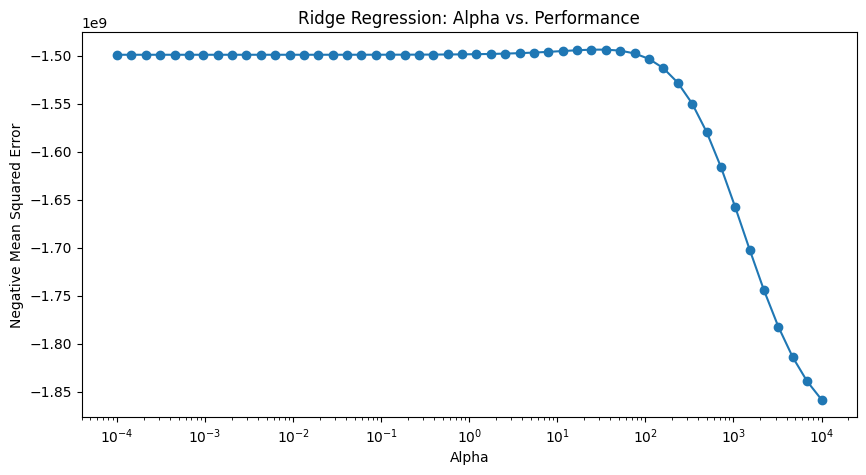

In [ ]:
alpha_vals, scores = zip(*ridge_scores)
plt.figure(figsize=(10, 5))
plt.plot(alpha_vals, scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Negative Mean Squared Error')
plt.title('Ridge Regression: Alpha vs. Performance')
plt.show()

In [48]:
train.shape[0]

1460

# Lasso Regression

---



In [79]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.feature_selection import SelectFromModel

# Copy training data to work with
train_df = train.copy(deep=True)
y = train_df['SalePrice']

# Drop 'ID' & 'SalePrice' columns
train_df.drop(columns=['Id','SalePrice'], inplace=True)

# Drop columns with too many NaNs (i.e more than 50% of column entries missing)
nan_threshold = 0.5
train_df.dropna(axis=1, thresh=int(nan_threshold * train_df.shape[0]),inplace=True)
# inplace=True ensures the dataset actually updates.
# axis=1 drops any column which with more than 'threshold' of its entries missing

# nan_percentage = train_df.isna().mean()  # Calculate percentage of NaNs in each column
# cols_to_drop = nan_percentage[nan_percentage > threshold].index  # Identify columns exceeding threshold

# ---------------------------------- Identify & Group Feature Types --------------------------------------

# Identify numerical and categorical features
numeric_feature_names = train_df.select_dtypes(include=[np.number]).columns.tolist()

cat_ord_feature_names = train_df.select_dtypes(include=["object"]).columns.tolist()

# Extract high-cardinality categorical features (categorical features with >10 unique categories)
cat_ord_feature_names_HCCF = [feature_name for feature_name in cat_ord_feature_names if train_df[feature_name].nunique() > 10]

# Extract low-cardinality categorical features (categorical features with >10 unique categories)
cat_ord_feature_names_LCCF = [feature_name for feature_name in cat_ord_feature_names if feature_name not in cat_ord_feature_names_HCCF]

# --------------------------------------- Feature Engineering -------------------------------------------

train_df["TotalSF"]    = train_df["TotalBsmtSF"] + train_df["1stFlrSF"] + train_df["2ndFlrSF"]
train_df["HouseAge"]   = train_df["YrSold"] - train_df["YearBuilt"]
train_df["RemodelAge"] = train_df["YrSold"] - train_df["YearRemodAdd"]
numeric_feature_names.extend(["TotalSF", "HouseAge", "RemodelAge"])
all_feature_names = numeric_feature_names + cat_ord_feature_names

# -------------------------- Define Feature/Column Transformation Pipelines -----------------------------

num_pipeline = Pipeline(
    steps = [('imputer', SimpleImputer(strategy='median')),
             ('scaler', StandardScaler())]
)

cat_pipeline_lccf = Pipeline(
    steps = [('cat_imputer', SimpleImputer(strategy='most_frequent')),
             ("encoder", OneHotEncoder(handle_unknown="ignore",sparse_output=False))]
)

cat_pipeline_hccf = Pipeline(
    steps = [('cat_imputer', SimpleImputer(strategy='most_frequent')),
             ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))]
    # OrdinalEncoder: Encode categorical features as an integer array. This results in a single column of integers (0 to n_categories - 1) per feature.
)

# -------------------------- Link Pipelines Together with ColumnTransformer -----------------------------

# ColumnTransformer is useful when you need to apply different transformations to different columns in a dataset, such as one-hot encoding for categorical features and scaling for numerical features.
preprocessor = ColumnTransformer(
    transformers=[
        # ('column_dropper_pipeline', column_dropper_pipeline, all_feature_names),
        ('num_pipeline', num_pipeline, numeric_feature_names),
        ('cat_pipeline_lccf', cat_pipeline_lccf, cat_ord_feature_names_LCCF),
        ('cat_pipeline_hccf', cat_pipeline_hccf, cat_ord_feature_names_HCCF) # input order: ('name', transformer, columns)
    ]
)

# -------------------------- Define Full Model Pipeline -----------------------------

lasso_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Lasso(alpha=10, max_iter=10000, selection='cyclic'))
])

# -------------------------- Train & Evaluate Model -----------------------------

X = train_df.copy(deep=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
lasso_model.fit(X_train, y_train)

# Evaluate model performance
CV_rmse_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")

# Why -RMSE? In scikit-learn, scoring functions are designed to be maximized. This means that higher scores are better. However, some metrics like Mean Squared Error (MSE) and Mean Absolute Error (MAE) are naturally minimized (lower values indicate better performance). To maintain consistency, scikit-learn returns these "negative" values so that cross_val_score() can always aim to maximize the score.

# Predictions
y_pred_train = lasso_model.predict(X_train) # Re-fit on training set
y_pred_test  = lasso_model.predict(X_test) # Evaluate on test set

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

train_r2 = r2_score(y_train, y_pred_train)
test_r2  = r2_score(y_test, y_pred_test)

print("----------- PERFORMANCE METRICS: TRAINING SET ---------------")
print("Cross-Validated RMSE:", -CV_rmse_scores.mean())
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R_sq: {train_r2:.4f}")

print("----------- PERFORMANCE METRICS: TEST SET ---------------")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R_sq: {test_r2:.4f}")

##############
# List of alpha values (log-spaced)
alpha_values = np.logspace(-4, 4, 50) # 50 values from 10^-4 to 10^4

# Store performance metrics
performance_metrics = []

for alpha in alpha_values:
    # Define Lasso model
    lasso_model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso(alpha=alpha, max_iter=10000))
    ])

    # Fit model
    lasso_model.fit(X_train, y_train)

    # Evaluate model performance
    CV_rmse_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")

    # Predict
    y_pred_train = lasso_model.predict(X_train)
    y_pred_test  = lasso_model.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store results
    performance_metrics.append({
        "alpha": alpha,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_r2": train_r2,
        "test_r2": test_r2
    })

----------- PERFORMANCE METRICS: TRAINING SET ---------------
Cross-Validated RMSE: 36772.63784422536
Train RMSE: 22051.2096
Train R_sq: 0.9185
----------- PERFORMANCE METRICS: TEST SET ---------------
Test RMSE: 29246.9122
Test R_sq: 0.8885


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.004e+09, tolerance: 5.796e+08
  model = cd_fast.enet_coordinate_descent(


In [67]:
CV_rmse_scores

array([-27524.58465803, -39110.28715409, -54574.302875  , -37283.03380561,
       -25370.98072839])

In [56]:
preprocessor.fit_transform(X_train).shape

(1168, 235)

In [ ]:
# Fix OneHotEncoder argument issue
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline_lccf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

cat_pipeline_hccf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, numeric_feature_names),
    ('cat_pipeline_lccf', cat_pipeline_lccf, cat_ord_feature_names_LCCF),
    ('cat_pipeline_hccf', cat_pipeline_hccf, cat_ord_feature_names_HCCF)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

# List of alpha values (log-spaced)
alpha_values = np.logspace(-4, 4, 50) # 50 values from 10^-4 to 10^4

# Store performance metrics
performance_metrics = []

for alpha in alpha_values:
    # Define Lasso model
    lasso_model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', Lasso(alpha=alpha, max_iter=10000))
    ])

    # Fit model
    lasso_model.fit(X_train, y_train)

    # Predict
    y_pred_train = lasso_model.predict(X_train)
    y_pred_test  = lasso_model.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Store results
    performance_metrics.append({
        "alpha": alpha,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_r2": train_r2,
        "test_r2": test_r2
    })

# Convert to DataFrame for visualization
performance_df = pd.DataFrame(performance_metrics)

# Plot RMSE
fig,axes = plt.subplots(1,2,figsize=(10, 5))
axes[0].plot(performance_df["alpha"], performance_df["train_rmse"], label="Train RMSE", marker="o")
axes[0].plot(performance_df["alpha"], performance_df["train_rmse"], label="Train RMSE", marker="o")
axes[0].plot(performance_df["alpha"], performance_df["test_rmse"], label="Test RMSE", marker="o")
axes[0].xscale("log")
axes[0].xlabel("Alpha")
axes[0].ylabel("RMSE")
axes[0].title("Lasso Regression: RMSE vs Alpha")
axes[0].legend()
axes[0].grid(False)

# Plot R²
axes[1].plot(performance_df["alpha"], performance_df["train_r2"], label="Train R²", marker="o")
axes[1].plot(performance_df["alpha"], performance_df["test_r2"], label="Test R²", marker="o")
axes[1].xscale("log")
axes[1].xlabel("Alpha")
axes[1].ylabel("R² Score")
axes[1].title("Lasso Regression: R² Score vs Alpha")
axes[1].legend()
axes[1].grid(False)
axes[1].show()


AttributeError: 'Axes' object has no attribute 'xscale'

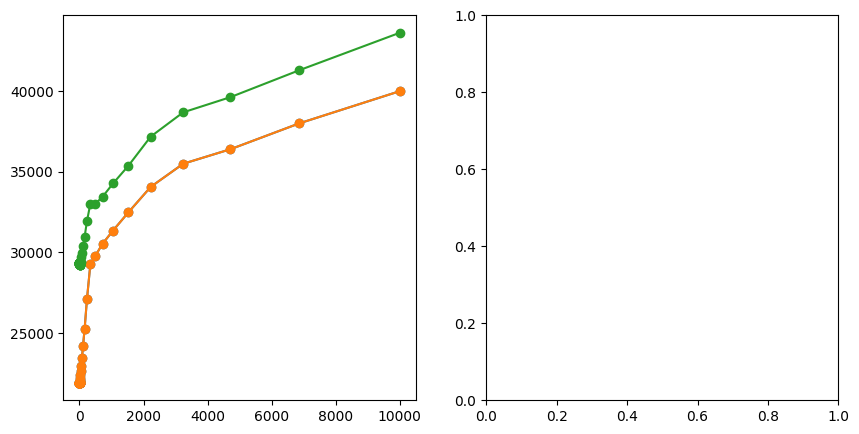

In [76]:
# Plot RMSE
fig,axes = plt.subplots(1,2,figsize=(10, 5))
axes[0].plot(performance_df["alpha"], performance_df["train_rmse"], label="Train RMSE", marker="o")
axes[0].plot(performance_df["alpha"], performance_df["test_rmse"], label="Test RMSE", marker="o")
axes[0].set_xscale("log") # Changed xscale to set_xscale
axes[0].set_xlabel("Alpha") # Changed xlabel to set_xlabel
axes[0].set_ylabel("RMSE") # Changed ylabel to set_ylabel
axes[0].set_title("Lasso Regression: RMSE vs Alpha") # Changed title to set_title
axes[0].legend()
axes[0].grid(False)

# Plot R²
axes[1].plot(performance_df["alpha"], performance_df["train_r2"], label="Train R²", marker="o")
axes[1].plot(performance_df["alpha"], performance_df["test_r2"], label="Test R²", marker="o")
axes[1].set_xscale("log") # Changed xscale to set_xscale
axes[1].set_xlabel("Alpha") # Changed xlabel to set_xlabel
axes[1].set_ylabel("R² Score") # Changed ylabel to set_ylabel
axes[1].set_title("Lasso Regression: R² Score vs Alpha") # Changed title to set_title
axes[1].legend()
axes[1].grid(False)
plt.show() # Added plt.show() to display the plot


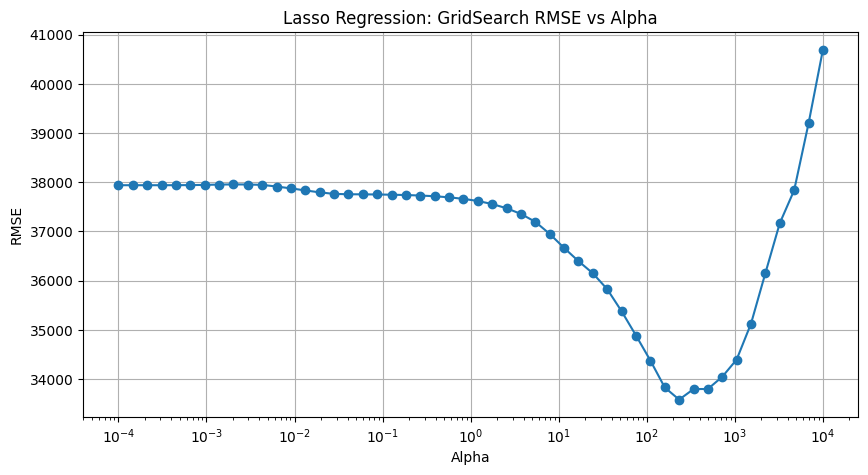

===== Lasso Grid Search Summary =====
   Best Alpha    Train RMSE     Test RMSE  Train R²   Test R²
0  232.995181  27082.084205  31915.320755  0.877034  0.867204


In [81]:

from sklearn.model_selection import train_test_split, GridSearchCV

# Define parameter grid
param_grid = {
    'model__alpha': np.logspace(-4, 4, 50)  # Search over a log scale of alpha values
}

# ------------------- Perform Grid Search -------------------
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['model__alpha']

# Predict using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Compute performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# ------------------- Store & Plot Grid Search Results -------------------
grid_results = pd.DataFrame(grid_search.cv_results_)[["param_model__alpha", "mean_test_score"]]
grid_results.rename(columns={"param_model__alpha": "alpha", "mean_test_score": "neg_rmse"}, inplace=True)
grid_results["rmse"] = -grid_results["neg_rmse"]

# Plot RMSE vs Alpha from Grid Search results
plt.figure(figsize=(10, 5))
plt.plot(grid_results["alpha"], grid_results["rmse"], marker="o", linestyle="-")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("Lasso Regression: GridSearch RMSE vs Alpha")
plt.grid()
plt.show()

# ------------------- Display Results -------------------
summary = pd.DataFrame({
    "Best Alpha": [best_alpha],
    "Train RMSE": [train_rmse],
    "Test RMSE": [test_rmse],
    "Train R²": [train_r2],
    "Test R²": [test_r2]
})

print("===== Lasso Grid Search Summary =====")
print(summary)


### Below we demonstrate how to apply the data transformers to the test data, generate predictions and then produce a Kaggle submission-ready .csv file

In [ ]:
# Apply the already created pipeline transformer to the test dataset
test_rdy = preprocessor.transform(test)
test_rdy.shape

(1459, 288)

In [ ]:
# We already 'fit' our model on the training data, so now that the test dataset is in the proper format
# we can apply the .predict() method to generate SalePrice predictions on our test dataset
pred = lasso_reg.predict(test_rdy)

In [ ]:
# Generate a DF object that will house our predictions (which currently reside in an array titled 'pred')
df = pd.DataFrame(index=np.arange(len(test)), columns=['Id', 'SalePrice'])
dfRig = pd.DataFrame(index=np.arange(len(test)), columns=['Id', 'SalePrice'])

In [ ]:
# Copy in the 'Id' column from the test dataset
# Copy in the predictions to the 'SalePrice' column
df['Id'] = test['Id']
df['SalePrice'] = pred
# View the output
df


,Id,SalePrice
0,1461,113638.882610
1,1462,155253.052933
2,1463,187956.317649
3,1464,201768.684769
4,1465,202917.340115
...,...,...
1454,2915,81752.833933
1455,2916,81452.457073
1456,2917,181854.351324
1457,2918,109862.324388


In [ ]:
dfRig['Id'] = test['Id']
dfRig['SalePrice'] = predRig
dfRig

,Id,SalePrice
0,1461,118976.045772
1,1462,145999.925553
2,1463,173894.518944
3,1464,198161.726993
4,1465,195652.894207
...,...,...
1454,2915,55561.007919
1455,2916,64583.428555
1456,2917,162264.909184
1457,2918,94716.197915


In [ ]:
# Let's get a quick understanding of the statistical descriptive characteristics of our
# predictions
df.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,180819.669969
std,421.321334,80552.336687
min,1461.000000,3215.597423
25%,1825.500000,127590.305563
50%,2190.000000,162148.238552
75%,2554.500000,215009.738298
max,2919.000000,756618.692683


In [ ]:
dfRig.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,174114.417902
std,421.321334,70245.369862
min,1461.000000,-3247.337413
25%,1825.500000,124321.050595
50%,2190.000000,164159.298767
75%,2554.500000,217748.719919
max,2919.000000,589459.740684


<Axes: ylabel='Frequency'>

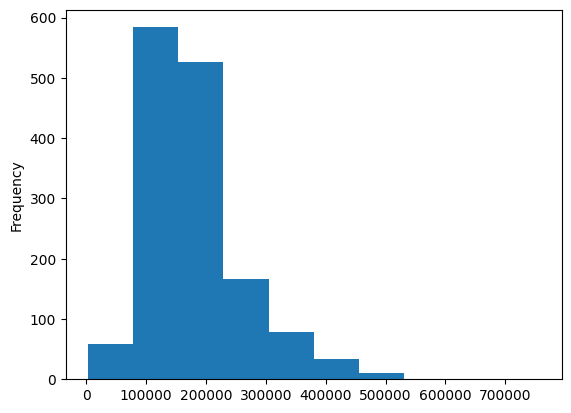

In [ ]:
# Plot a histogram of the SalePrice column
df['SalePrice'].plot.hist()

<Axes: ylabel='Frequency'>

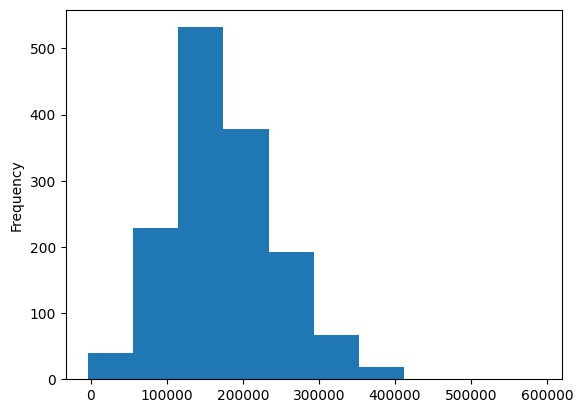

In [ ]:
dfRig['SalePrice'].plot.hist()

In [ ]:
# Use the .to_csv() method in Pandas to output our results to a .csv file for submission to Kaggle
df.to_csv('./simple_lasso_pred.csv', index=False)
dfRig.to_csv('./optimized_ridge_pred.csv', index=False)